# Прогнозирование землятрясений в Японии



In [ ]:

import numpy as np
import pandas as pd 
import datetime


import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium import *
from folium.plugins import *

        
import pandas as pd
import os
from subprocess import check_output

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix

from pathlib import Path



# Анализируем данные

In [ ]:
train_data = pd.read_csv("Japan earthquakes 2001 - 2018.csv")

In [ ]:
print(train_data.columns.values) #

['time' 'latitude' 'longitude' 'depth' 'mag' 'magType' 'nst' 'gap' 'dmin'
 'rms' 'net' 'id' 'updated' 'place' 'type' 'horizontalError' 'depthError'
 'magError' 'magNst' 'status' 'locationSource' 'magSource']


In [ ]:
train_data.head() 

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2018-11-27T14:34:20.900Z,48.3780,154.9620,35.00,4.9,mb,NaN,92.0,5.044,0.63,...,2018-11-27T16:06:33.040Z,"269km SSW of Severo-Kuril'sk, Russia",earthquake,7.6,1.7,0.036,248.0,reviewed,us,us
1,2018-11-26T23:33:50.630Z,36.0733,139.7830,48.82,4.8,mww,NaN,113.0,1.359,1.13,...,2018-11-27T16:44:22.223Z,"3km SSW of Sakai, Japan",earthquake,6.0,6.1,0.071,19.0,reviewed,us,us
2,2018-11-26T13:04:02.250Z,38.8576,141.8384,50.56,4.5,mb,NaN,145.0,1.286,0.84,...,2018-11-26T23:52:21.074Z,"26km SSE of Ofunato, Japan",earthquake,8.4,9.5,0.156,12.0,reviewed,us,us
3,2018-11-26T05:20:16.440Z,50.0727,156.1420,66.34,4.6,mb,NaN,128.0,3.191,0.62,...,2018-11-26T08:13:58.040Z,"67km S of Severo-Kuril'sk, Russia",earthquake,9.7,7.8,0.045,151.0,reviewed,us,us
4,2018-11-25T09:19:05.010Z,33.9500,134.4942,38.19,4.6,mb,NaN,104.0,0.558,0.61,...,2018-11-25T23:24:52.615Z,"9km SW of Komatsushima, Japan",earthquake,3.4,10.1,0.132,17.0,reviewed,us,us


In [ ]:
train_data.shape

(14092, 22)

In [ ]:
train_data.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,14092.000000,14092.000000,14092.000000,14092.000000,10483.000000,13310.000000,3607.000000,14014.000000,2800.000000,9040.000000,3431.000000,11048.000000
mean,37.410294,142.980441,51.364838,4.817045,117.352094,104.272149,2.359796,0.876561,7.288607,7.822920,0.095182,48.590695
std,6.605873,6.552510,76.603810,0.378618,123.273889,37.893474,1.658681,0.203787,2.263028,5.861948,0.060710,70.233727
min,23.532900,124.293000,0.000000,4.500000,5.000000,8.000000,0.038000,0.120000,1.400000,0.000000,0.019000,1.000000
25%,33.147675,141.071000,14.400000,4.600000,36.000000,78.000000,1.109000,0.740000,5.800000,4.400000,0.054000,9.000000
50%,37.357000,142.452100,35.000000,4.700000,69.000000,112.700000,1.979000,0.850000,7.100000,6.200000,0.079000,23.000000
75%,42.271325,144.432000,50.372500,4.900000,153.000000,130.900000,3.122500,0.990000,8.500000,9.600000,0.118000,57.000000
max,50.816100,158.818000,683.360000,9.100000,929.000000,306.600000,18.781000,1.880000,25.600000,70.700000,0.555000,941.000000


In [ ]:
train_data.isnull().sum()

time                   0
latitude               0
longitude              0
depth                  0
mag                    0
magType                0
nst                 3609
gap                  782
dmin               10485
rms                   78
net                    0
id                     0
updated                0
place                  0
type                   0
horizontalError    11292
depthError          5052
magError           10661
magNst              3044
status                 0
locationSource         0
magSource              0
dtype: int64

### Предобработка данных

#### выбираем необходимые нам столбцы

In [ ]:
train_data = train_data[['time','latitude', 'longitude', 'depth','mag','place']]

Выберем только 6 столбецов, потому что другие переменные в наборе данных являются значениями, которые не используются и представляют только метаданные, такие как спецификации используемого прибора для измерения местоположения и погрешности.

In [ ]:
NAs = pd.concat([train_data.isnull().sum()], axis=1, keys=['null'])
NAs[NAs.sum(axis=1) > 0]

,null


Проверим данные в столбце, из которого удалены значения null.

Создадим функциональный элемент для разделения названия города и страны из поля "Place" в нескольких форматах данных.

Разделим на несколько столбцов место

In [ ]:
train_data[['temp', 'country']] = train_data['place'].str.split(',\s+', expand=True)

train_data[['country','place']].groupby(['country']).count().rename(columns={"place":"count"})

,count
country,
China,14
Japan,8675
Japan region,2164
North Korea,8
Russia,617
South Korea,8


Учитывая наличие данных из других стран, мы решили удалить их, так как мы заинтересованы только в Японии. Кроме того, в Японии есть 2 формата: Japan и Japan region, которые мы объединим в один.

In [ ]:
train_data = train_data[~train_data['country'].isin(['China','North Korea','Russia','South Korea'])]
train_data.loc[:, 'country'] = train_data['country'].fillna(value=np.nan)
train_data['country'] = train_data['country'].replace('Japan region', 'Japan')
train_data['country'] = train_data['country'].replace(np.nan, 'Japan')
train_data[['country','place']].groupby(['country']).count().rename(columns={"place":"count"})


<ipython-input-11-749c421f6fbf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'country'] = train_data['country'].fillna(value=np.nan)
<ipython-input-11-749c421f6fbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['country'] = train_data['country'].replace('Japan region', 'Japan')
<ipython-input-11-749c421f6fbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,count
country,
Japan,13445


после фильтрации данных все они стали относиться к Японии. Это было сделано путем использования функции split из строки, так что некоторые поля были пустыми и имели значение Null, и Япония была помещена во временный столбец. Затем Япония была перенесена в столбец country, что дало общее количество строк равное 13445.


Просмотрим значения среднего и стандартного отклонения в данных

In [ ]:
train_data.describe()

,latitude,longitude,depth,mag
count,13445.000000,13445.000000,13445.000000,13445.000000
mean,36.988671,142.726293,49.440565,4.815619
std,6.443873,6.427890,73.036612,0.376838
min,23.532900,124.293000,0.000000,4.500000
25%,32.696900,141.014000,14.000000,4.600000
50%,37.212000,142.374000,34.940000,4.700000
75%,40.969000,144.074000,49.100000,4.900000
max,50.802000,158.670000,683.360000,9.100000


Магнитуда землетрясения составляет 4,8 баллов

Стандартное отклонение [mag] низкое, равно 0,37, данные не разбросаны
Межквартильный размах находится в диапазоне от 4,6 до 4,9, относительно узкий
Средняя глубина эпицентра землетрясения составляет 51,36 км
Стандартное отклонение глубины эпицентра землетрясения = 76,603 км
Координаты эпицентра землетрясения от среднего значения широты 37,410294, долготы 142,980441.

###меняем формат даты в формат unix

In [ ]:
train_data['time'] = pd.to_datetime(train_data['time'],format= '%Y-%m-%dT%H:%M:%S') 
train_data['timestamp'] = train_data.time.values.astype(np.int64) 
train_data.head()

,time,latitude,longitude,depth,mag,place,temp,country,timestamp
1,2018-11-26 23:33:50.630000+00:00,36.0733,139.7830,48.82,4.8,"3km SSW of Sakai, Japan",3km SSW of Sakai,Japan,1543275230630000000
2,2018-11-26 13:04:02.250000+00:00,38.8576,141.8384,50.56,4.5,"26km SSE of Ofunato, Japan",26km SSE of Ofunato,Japan,1543237442250000000
4,2018-11-25 09:19:05.010000+00:00,33.9500,134.4942,38.19,4.6,"9km SW of Komatsushima, Japan",9km SW of Komatsushima,Japan,1543137545010000000
6,2018-11-23 14:30:14.510000+00:00,37.1821,141.1721,46.76,5.2,"29km ENE of Iwaki, Japan",29km ENE of Iwaki,Japan,1542983414510000000
7,2018-11-23 07:19:51.110000+00:00,29.3424,142.3121,10.00,4.7,"250km N of Chichi-shima, Japan",250km N of Chichi-shima,Japan,1542957591110000000


In [ ]:
train_data['day_of_week'] = pd.to_datetime(train_data['time']).dt.weekday+1
train_data['month'] = pd.to_datetime(train_data['time']).dt.month
train_data['year'] = pd.to_datetime(train_data['time']).dt.year


Согласно данным, разделенным на типы данных, следующее:
Категориальный тип столбцов с числовыми значениями

Категориальные: day_of_week,day_of_week_name,month,year
Числовой тип столбцов

Непрерывные: time,latitude,longitude,depth,mag.

Найдем информацию о том, какие землетрясения происходят часто каждый месяц в каждом году
Исходя из имеющихся данных, будет выбрано отображение в виде тепловой карты, где горизонтальная ось будет представлять год, а вертикальная ось - месяц.

<Axes: xlabel='year', ylabel='month'>

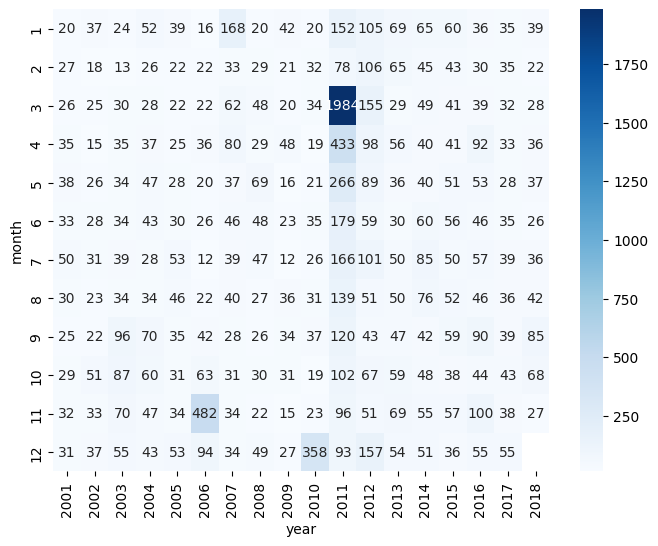

In [ ]:
pt = train_data.pivot_table(index="month",columns="year",values="mag", aggfunc="count") 
fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(pt,cmap="Blues",annot=True,fmt='g')


Согласно результатам анализа, количество землетрясений в каждый период времени примерно одинаково. Вывод из этого - землетрясения - это событие, которое может происходить в любое время, и не имеет четкой закономерности.

# Анализ визуализации данных


In [ ]:
import folium
from folium import plugins
from folium.plugins import HeatMap

map_hooray = folium.Map(location=[38.495035, 137.026582],
                    zoom_start = 4) 


xx = train_data
xx['latitude'] = xx['latitude'].astype(float)
xx['longitude'] = xx['longitude'].astype(float)


xx = xx[['latitude', 'longitude']]
xx = xx.dropna(axis=0, subset=['latitude','longitude'])

xx = [[row['latitude'],row['longitude']] for index, row in xx.iterrows()]


HeatMap(xx,min_opacity=0.4,radius=16, blur=10).add_to(map_hooray)


map_hooray

Изображение позиции землетрясения было построено на тепловой карте, где красные области указывают на то, что в этом месте произошло множество землетрясений. В большинстве случаев землетрясения происходят в море, чем на суше, а места, где происходят на суше, чаще всего являются городами Токио и южными городами региона. Форма позиции землетрясения имеет ряд выступов, которые соответствуют маленьким островам в море, а землетрясения происходят в основном на восточном побережье Японии.

### График глубины землетрясений, показывающий уровни каждого землетрясения.

<ipython-input-19-a954a583c71a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['mag'], hist=True, kde=True,


,count
mag,
4.5,2885
4.6,2637
4.7,2147
4.8,1615
4.9,1141
5.0,720
5.1,509
5.2,372
5.3,300


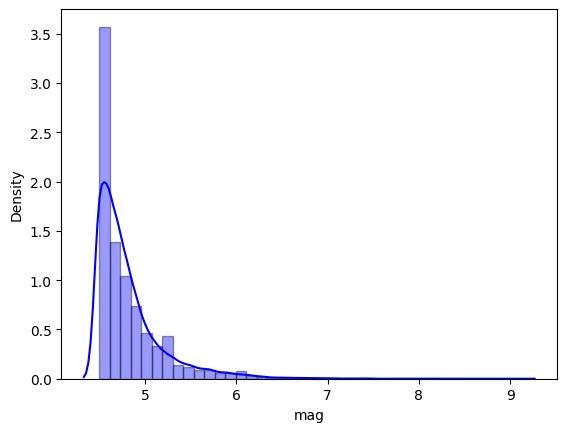

In [ ]:
mgchart = train_data[['latitude','mag']].groupby(['mag']).count().rename(columns={"latitude":"count"})
sns.distplot(train_data['mag'], hist=True, kde=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'})
mgchart.head(15)

### График силы землетрясения, чтобы узнать, какие уровни происходят чаще или реже.

<ipython-input-20-9feb3997535f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['depth'], hist=True, kde=True,


,count
depth,
0.0,2
0.6,1
0.7,3
1.0,2
1.1,1


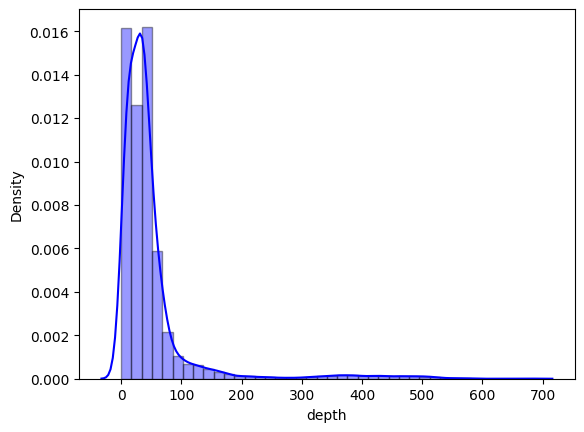

In [ ]:
mgchart2 = train_data[['latitude','depth']].groupby(['depth']).count().rename(columns={"latitude":"count"})
sns.distplot(train_data['depth'], hist=True, kde=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'})
mgchart2.head()

Как правило, сильнейшие землетрясения происходят на уровне 4,5-5 баллов по шкале Рихтера. Мы можем разделить уровень силы (mag) на категории и использовать его в модели.

4.0 - 4.9 Легкое землетрясение (Light) = 1
5.0 - 5.9 Умеренное землетрясение (Moderate) = 2
6.0 - 6.9 Сильное землетрясение (Strong) = 3
7.0 - 7.9 Крупное землетрясение (Major) = 4
Более 8.0 Очень крупное землетрясение (Great) = 5

In [ ]:
train_data['temp'] = train_data['temp'].str.replace("the","")
train_data[['temp1','temp2']] = train_data['temp'].str.split(' of ', expand = True)
train_data.temp2.fillna(value=pd.np.nan, inplace=True)
#pd.set_option('display.max_rows', 1000)
train_data.loc[train_data["temp2"].isnull(),'temp2'] = train_data["temp1"];
train_data=train_data.rename(columns={"temp2":"city"})
train_data = train_data[['time','latitude', 'longitude', 'depth', 'mag','city']]
train_data = train_data[~train_data['city'].isin(['China-Russia-North Korea border region','North Korea','South Korea','Taiwan','Japan','eastern Russia-norastern China border region'])] 
train_data['city'] = train_data['city'].replace('eastern Honshu', 'Honshu')
train_data['city'] = train_data['city'].replace('western Honshu', 'Honshu')
train_data['city'] = train_data['city'].replace('southwestern Ryukyu Islands', 'Ryukyu Islands')
display_grouped = train_data[['city','mag']].groupby(['city']).count().rename(columns={"mag":"count"})
display_grouped.sort_values('count', ascending=False)

<ipython-input-21-f1e97e99c57c>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  train_data.temp2.fillna(value=pd.np.nan, inplace=True)


,count
city,
Honshu,5062
Kuril Islands,1789
Bonin Islands,858
Kuril Islands,676
Izu Islands,617
...,...
Oi,1
Kashima,1
Ogawa,1


разделяем магнитуду на три класса по принципу слабое землятрясение, среднее и сильное

In [ ]:
bins = [4, 5, 6, np.inf]
names = ['1', '2', '3']
train_data['mag_cat'] = pd.cut(train_data['mag'], bins, labels=names)

In [ ]:
train_data

,time,latitude,longitude,depth,mag,city,mag_cat
1,2018-11-26 23:33:50.630000+00:00,36.0733,139.7830,48.82,4.8,Sakai,1
2,2018-11-26 13:04:02.250000+00:00,38.8576,141.8384,50.56,4.5,Ofunato,1
4,2018-11-25 09:19:05.010000+00:00,33.9500,134.4942,38.19,4.6,Komatsushima,1
6,2018-11-23 14:30:14.510000+00:00,37.1821,141.1721,46.76,5.2,Iwaki,2
7,2018-11-23 07:19:51.110000+00:00,29.3424,142.3121,10.00,4.7,Chichi-shima,1
...,...,...,...,...,...,...,...
14087,2001-01-04 04:18:21.430000+00:00,36.9810,138.6290,21.40,5.3,Honshu,2
14088,2001-01-03 14:47:49.540000+00:00,43.9320,147.8130,33.00,5.9,Kuril Islands,2
14089,2001-01-03 09:32:54.710000+00:00,45.3010,149.9410,33.00,4.6,Kuril Islands,1
14090,2001-01-02 20:29:49.670000+00:00,32.2390,141.5080,33.00,4.9,Izu Islands,1


In [ ]:
train_data[['mag_cat','city']].groupby(['mag_cat']).count().rename(columns={"mag":"% of count"}).rename(columns={"country":"city"})

,city
mag_cat,
1,11572
2,2175
3,233



Количество землетрясений при разных уровнях силы можно заметить, что землетрясения с высокой силой происходят реже.

### Отобразить уровни сейсмической активности на тепловой карте и посмотреть, где находятся точки с высокой сейсмической активностью.

In [ ]:
map_hooray2 = folium.Map(location=[38.495035, 137.026582],
                    zoom_start = 4) 

yy = train_data.loc[train_data['mag']>=7]
yy['latitude'] = yy['latitude'].astype(float)
yy['longitude'] = yy['longitude'].astype(float)

yy = yy[['latitude', 'longitude']]
yy = yy.dropna(axis=0, subset=['latitude','longitude'])

yy = [[row['latitude'],row['longitude']] for index, row in yy.iterrows()]

HeatMap(yy,min_opacity=0.8,radius=20, blur=10).add_to(map_hooray2)

map_hooray2

<ipython-input-24-8cdbc48fe2d2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yy['latitude'] = yy['latitude'].astype(float)
<ipython-input-24-8cdbc48fe2d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yy['longitude'] = yy['longitude'].astype(float)



Хитмэп показывает, где произошли землетрясения магнитудой 4 и 5, и некоторые красные точки указывают на повторяющиеся эпицентры. Поэтому области, близкие к точкам с высокой интенсивностью, могут быть опасными. На основе этого можно использовать координаты Lat/Long как переменные для создания модели, чтобы определить, какие места более подвержены риску.

In [ ]:
# city = pd.get_dummies(train_data['city'])
X = pd.concat([train_data['longitude'],train_data['latitude'],train_data['depth']], axis = 1)
#X = pd.get_dummies(train_data['city'])
y = train_data[['mag_cat']]

X

,longitude,latitude,depth
1,139.7830,36.0733,48.82
2,141.8384,38.8576,50.56
4,134.4942,33.9500,38.19
6,141.1721,37.1821,46.76
7,142.3121,29.3424,10.00
...,...,...,...
14087,138.6290,36.9810,21.40
14088,147.8130,43.9320,33.00
14089,149.9410,45.3010,33.00
14090,141.5080,32.2390,33.00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44, stratify=y)

print(X.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13333, 3)
(10666, 3) (2667, 3) (10666, 1) (2667, 1)


-------------------------------------------------

In [ ]:
# Support Vector Machines
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


82.96

### Linear SVC

In [ ]:
# Linear SVC
from sklearn import svm
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
linear_svc_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


42.8

## RandomForest Model

In [ ]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=2)
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
# f1_random_forest = round(f1_score(y_test, random_forest_pred, average='macro')* 100, 2)

acc_random_forest

<ipython-input-29-dbffdf528a90>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


91.13

In [ ]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=1, n_neighbors=5, p=2,)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_test, y_test) * 100, 2)
# f1_knn = round(f1_score(y_test, knn_pred, average='macro')* 100, 2)
acc_knn

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


81.03

### LGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(objective='multiclass', random_state=44)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
acc_lgbm = round(lgbm.score(X_train, y_train) * 100, 2)
# f1_lgbm = round(f1_score(y_test, lgbm_pred, average='macro')* 100, 2)
acc_lgbm

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


84.46

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 
              'Random Forest', 'LightGBM', 'Linear SVC'],
    'Accuracy': [acc_svc, acc_knn,
              acc_random_forest, acc_lgbm, acc_linear_svc],
    # 'F1': [f1_svc, f1_knn,f1_random_forest, f1_lgbm, f1_linear_svc]
})
models.sort_values(by='Accuracy', ascending=False)


,Model,Accuracy
2,Random Forest,91.13
3,LightGBM,84.46
0,Support Vector Machines,82.96
1,KNN,81.03
4,Linear SVC,42.80


# Нейронные сети

In [ ]:
# Импорт необходимых библиотек
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

# Преобразование целевых переменных в числа - 0 это 1, 0.25 это 2 и т.д.
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)

# Преобразование целевых переменных в категориальные значения под TensorFlow
y_train_categorical = to_categorical(y_train_int, num_classes=len(np.unique(y_train_int)))
y_test_categorical = to_categorical(y_test_int, num_classes=len(np.unique(y_train_int)))

# Преобразование признаков в нужный формат для нейронной сети
X_train_reshaped = X_train.values.reshape(-1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1])

# Создание модели нейронной сети:
# Входной слой -> Скрытый слой из 32 нейронов -> Скрытый слой из 16 нейронов -> Скрытый слой из 8 нейронов -> Выходной слой с функцией активации Softmax
model_dense = Sequential()
model_dense.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))  # Первый слой
model_dense.add(Dense(16, activation='relu'))  # Второй слой
model_dense.add(Dense(8, activation='relu'))  # Третий слой
model_dense.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Выходной слой

# Задание оптимизатора, функции потерь и метрики, по которой будет оцениваться модель
model_dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели с 10 эпохами и размером батча 32
model_dense.fit(X_train_reshaped, y_train_categorical, epochs=10, batch_size=32, verbose=2)

# Получение предсказаний и оценка точности модели на обучающей выборке
dense_pred = np.argmax(model_dense.predict(X_test_reshaped),axis=1)
acc_dense = round(model_dense.evaluate(X_train_reshaped, y_train_categorical, verbose=0)[1]*100, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
667/667 - 1s - loss: 0.6288 - accuracy: 0.8222 - 1s/epoch - 2ms/step
Epoch 2/10
667/667 - 1s - loss: 0.5333 - accuracy: 0.8262 - 788ms/epoch - 1ms/step
Epoch 3/10
667/667 - 1s - loss: 0.5347 - accuracy: 0.8271 - 839ms/epoch - 1ms/step
Epoch 4/10
667/667 - 1s - loss: 0.5199 - accuracy: 0.8270 - 784ms/epoch - 1ms/step
Epoch 5/10
667/667 - 1s - loss: 0.5185 - accuracy: 0.8278 - 643ms/epoch - 964us/step
Epoch 6/10
667/667 - 1s - loss: 0.5174 - accuracy: 0.8291 - 631ms/epoch - 946us/step
Epoch 7/10
667/667 - 1s - loss: 0.5144 - accuracy: 0.8291 - 647ms/epoch - 971us/step
Epoch 8/10
667/667 - 1s - loss: 0.5125 - accuracy: 0.8290 - 634ms/epoch - 951us/step
Epoch 9/10
667/667 - 1s - loss: 0.5106 - accuracy: 0.8289 - 636ms/epoch - 954us/step
Epoch 10/10
667/667 - 1s - loss: 0.5098 - accuracy: 0.8296 - 626ms/epoch - 939us/step
84/84 [==============================] - 0s 823us/step


In [ ]:
from sklearn.metrics import accuracy_score


y_test_int = le.transform(y_test)
y_pred_int = le.inverse_transform(dense_pred)

accuracy = accuracy_score(y_test_int, dense_pred)
print("Accuracy score:", accuracy)


Accuracy score: 0.8293963254593176


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()

#архитектура входной слой - ЛСТМ слой на 32 нейрона - выходной слой
model_lstm.add(LSTM(32, input_shape=(X_train.shape[1], 1)))  # LSTM слой
model_lstm.add(Dense(len(np.unique(y_train)), activation='softmax'))  # выходной слой
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_lstm.fit(X_train_reshaped, y_train_categorical, epochs=5, batch_size=32, verbose=2)

#получение предсказаний
lstm_pred = np.argmax(model_lstm.predict(X_test_reshaped),axis=1)
acc_lstm = round(model_lstm.evaluate(X_train_reshaped, y_train_categorical, verbose=0)[1]*100, 2)

Epoch 1/5
350/350 - 3s - loss: 0.6278 - accuracy: 0.7598 - 3s/epoch - 9ms/step
Epoch 2/5
350/350 - 1s - loss: 0.5138 - accuracy: 0.8278 - 1s/epoch - 3ms/step
Epoch 3/5
350/350 - 1s - loss: 0.5129 - accuracy: 0.8278 - 1s/epoch - 3ms/step
Epoch 4/5
350/350 - 1s - loss: 0.5129 - accuracy: 0.8278 - 1s/epoch - 3ms/step
Epoch 5/5
350/350 - 1s - loss: 0.5121 - accuracy: 0.8278 - 1s/epoch - 3ms/step
88/88 [==============================] - 1s 2ms/step


In [ ]:
# Импортируем необходимые слои из keras
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout

# Создаем пустую модель с помощью класса Sequential
model_cnn = Sequential()

# Добавляем слои в модель поочередно: 
# Входной слой - одномерная свертка - дропаут - максимальное объединение (pooling) - плоский слой (Flatten) - полносвязный слой на 16 нейронов - дропаут - выходной слой с активацией softmax
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(Dropout(0.2))
model_cnn.add(MaxPooling1D(pool_size=1))
model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Компилируем модель с категориальным кросс-энтропийным лоссом, оптимизатором Адам и метрикой accuracy
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучаем модель на тренировочных данных, используя one-hot-encoding для меток, на 5 эпохах, с размером батча 32 и выводим прогресс на экране
model_cnn.fit(X_train_reshaped, y_train_categorical, epochs=5, batch_size=32, verbose=2)

# Получаем предсказания модели на тестовых данных и переводим их в индексы меток с наибольшей вероятностью
cnn_pred = np.argmax(model_cnn.predict(X_test_reshaped),axis=1)

# Вычисляем точность модели на тренировочных данных и округляем до двух знаков после запятой
acc_cnn = round(model_cnn.evaluate(X_train_reshaped, y_train_categorical, verbose=0)[1]*100, 2)

Epoch 1/5
350/350 - 1s - loss: 4.8555 - accuracy: 0.6430 - 1s/epoch - 4ms/step
Epoch 2/5
350/350 - 1s - loss: 0.7432 - accuracy: 0.8198 - 551ms/epoch - 2ms/step
Epoch 3/5
350/350 - 1s - loss: 0.6218 - accuracy: 0.8245 - 605ms/epoch - 2ms/step
Epoch 4/5
350/350 - 1s - loss: 0.5779 - accuracy: 0.8266 - 569ms/epoch - 2ms/step
Epoch 5/5
350/350 - 1s - loss: 0.5580 - accuracy: 0.8263 - 549ms/epoch - 2ms/step
88/88 [==============================] - 0s 1ms/step


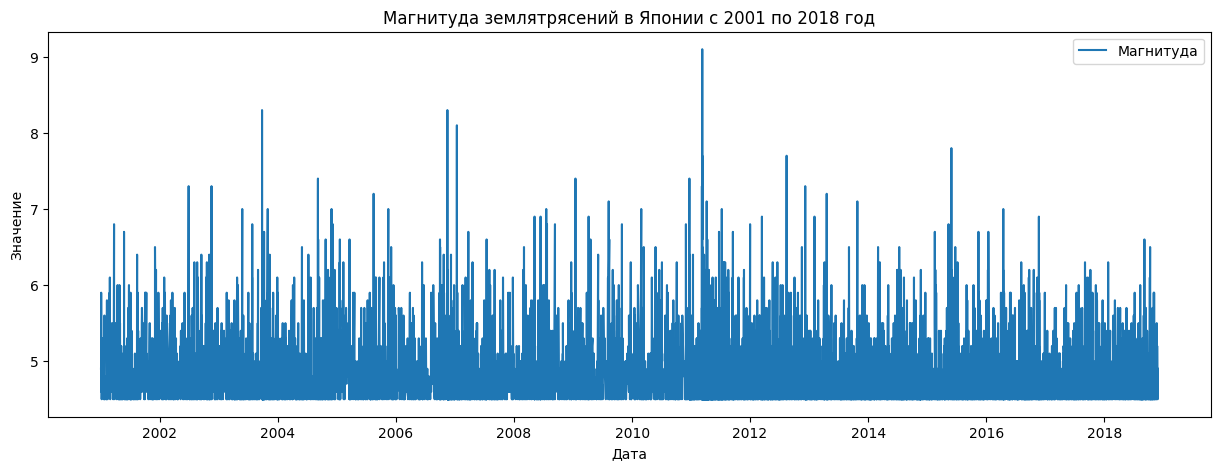

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train_data['time'], train_data['mag'], label='Магнитуда')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Магнитуда землятрясений в Японии с 2001 по 2018 год')
plt.legend()
plt.show()
